In [1]:
#IMPORTING NECESSARY LIBRARIES
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import string
from tqdm import tqdm
from multiprocessing import Pool
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, \
roc_auc_score, roc_curve, precision_score, recall_score

import warnings 
warnings.filterwarnings('ignore')

In [2]:
#LOADING THE DATASET 
df = pd.read_csv('Tweets.csv')
df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [3]:
#Let's drop selected text & text id column which are unnecessary
df.drop(['selected_text', 'textID'], axis=1, inplace=True)
target = 'sentiment'
df.reset_index(drop=True, inplace=True) #Resetting the index
original_df = df.copy(deep=True)
df.head()

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative


In [4]:
#Dimensions of the dataset & information about dataset
print('Dimentions of dataset:', df.shape)
#Checking the dtypes of all the columns
df.info()

Dimentions of dataset: (27481, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       27480 non-null  object
 1   sentiment  27481 non-null  object
dtypes: object(2)
memory usage: 429.5+ KB


In [5]:
#Descriptive summary of dataset
df.describe()

,text,sentiment
count,27480,27481
unique,27480,3
top,"I`d have responded, if I were going",neutral
freq,1,11118


In [6]:
#Let's check Null values
df.isnull().sum()

text         1
sentiment    0
dtype: int64

In [7]:
#Dropping the null values
df.dropna(inplace=True)
original_df = df.copy()

In [8]:
#Let's check Duplicates
df.duplicated().sum()

0

In [9]:
# Let's get a word count 
df['word_count'] = df['text'].apply(lambda x: len(str(x).split(" ")))
df[['text','word_count']].head()

,text,word_count
0,"I`d have responded, if I were going",8
1,Sooo SAD I will miss you here in San Diego!!!,11
2,my boss is bullying me...,5
3,what interview! leave me alone,6
4,"Sons of ****, why couldn`t they put them on t...",15


In [10]:
#Number of Characters- including spaces
df['char_count'] = df['text'].str.len() # this also includes spaces
df[['text','char_count']].head()

,text,char_count
0,"I`d have responded, if I were going",36
1,Sooo SAD I will miss you here in San Diego!!!,46
2,my boss is bullying me...,25
3,what interview! leave me alone,31
4,"Sons of ****, why couldn`t they put them on t...",75


In [11]:
#Average Word Length:
def avg_word(sentence):
    words = sentence.split()
    return (sum(len(word) for word in words)/len(words))
df['avg_word'] = df['text'].apply(lambda x: avg_word(x))
df[['text','avg_word']].head()

,text,avg_word
0,"I`d have responded, if I were going",4.142857
1,Sooo SAD I will miss you here in San Diego!!!,3.600000
2,my boss is bullying me...,4.200000
3,what interview! leave me alone,5.200000
4,"Sons of ****, why couldn`t they put them on t...",4.357143


In [12]:
#Number of stop Words:
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

df['stopwords'] = df['text'].apply(lambda x: len([x for x in x.split() if x in stop]))
df[['text','stopwords']].head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,text,stopwords
0,"I`d have responded, if I were going",3
1,Sooo SAD I will miss you here in San Diego!!!,4
2,my boss is bullying me...,2
3,what interview! leave me alone,2
4,"Sons of ****, why couldn`t they put them on t...",7


In [13]:
#Number of special character:
df['hastags'] = df['text'].apply(lambda x: len([x for x in x.split() if x.startswith('@')]))
df[['text','hastags']].head()

,text,hastags
0,"I`d have responded, if I were going",0
1,Sooo SAD I will miss you here in San Diego!!!,0
2,my boss is bullying me...,0
3,what interview! leave me alone,0
4,"Sons of ****, why couldn`t they put them on t...",0


In [14]:
#Number of numerics:
df['numerics'] = df['text'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
df[['text','numerics']].head()

,text,numerics
0,"I`d have responded, if I were going",0
1,Sooo SAD I will miss you here in San Diego!!!,0
2,my boss is bullying me...,0
3,what interview! leave me alone,0
4,"Sons of ****, why couldn`t they put them on t...",0


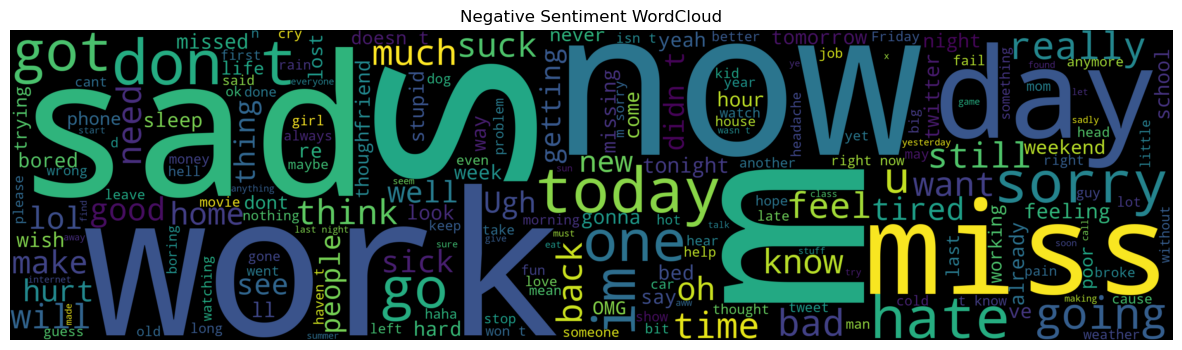

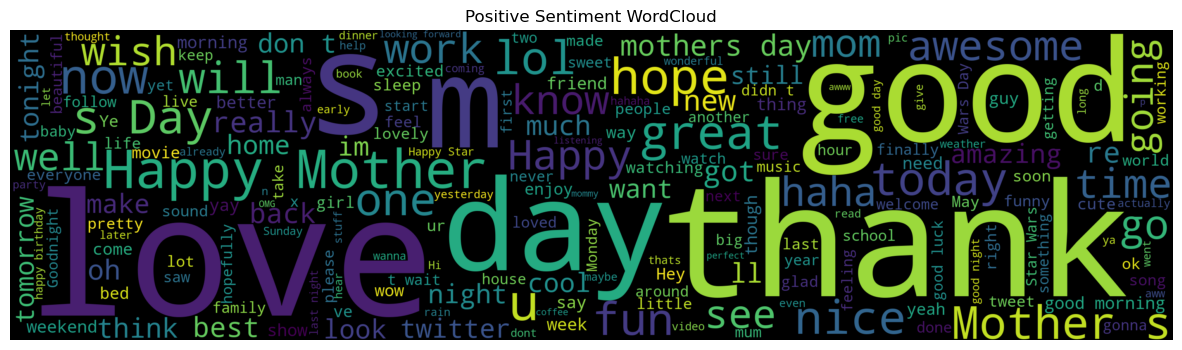

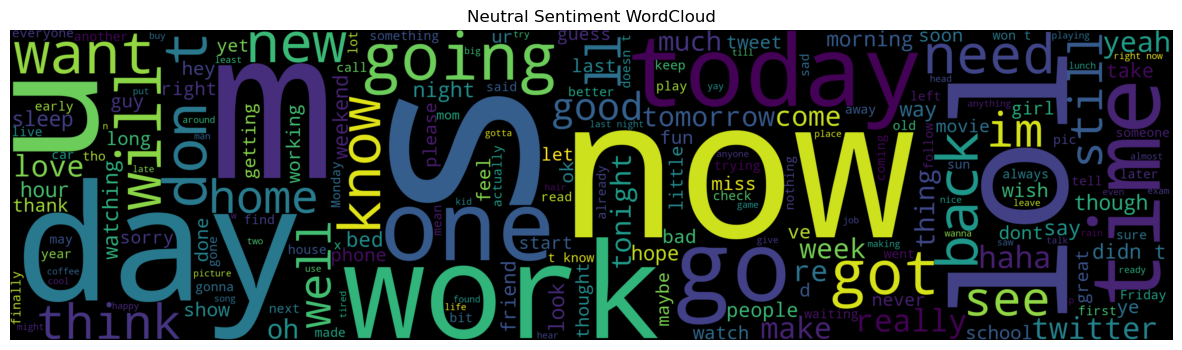

In [15]:
#WORDCLOUD
from wordcloud import WordCloud, STOPWORDS
negative_df = df[df['sentiment'] == 'negative']
positive_df = df[df['sentiment'] == 'positive']
neutral_df = df[df['sentiment'] == 'neutral']

# Define a function to generate and display a WordCloud
def generate_wordcloud(data, title):
    words = ' '.join(data['text'])
    cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT' ])
    wordcloud = WordCloud(stopwords=STOPWORDS,background_color='black', 
                          width=3000, height=800).generate(cleaned_word)
    plt.figure(figsize=(15, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()
# Generate and display WordClouds for each sentiment category
generate_wordcloud(negative_df, 'Negative Sentiment WordCloud')
generate_wordcloud(positive_df, 'Positive Sentiment WordCloud')
generate_wordcloud(neutral_df, 'Neutral Sentiment WordCloud')

In [16]:
#BASIC PREPROCESSING
# Convert text to lowercase
df['text'] = df['text'].apply(lambda x: " ".join(x.lower() for x in x.split()))

# Removal of punctuations
df['text'].str.replace('[^\w\s]','')

#Removal of StopWords
from nltk.corpus import stopwords
stop = stopwords.words('english')
df['text'] = df['text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
df['text'].head()

0                               i`d responded, going
1                         sooo sad miss san diego!!!
2                                boss bullying me...
3                             interview! leave alone
4    sons ****, couldn`t put releases already bought
Name: text, dtype: object

In [17]:
freq = pd.Series(' '.join(df['text']).split()).value_counts()[:30]
freq

i`m       2173
day       1481
get       1415
good      1325
like      1303
it`s      1174
go        1162
-         1147
got       1069
going     1062
love      1060
happy      914
work       878
don`t      850
u          848
really     841
one        838
im         824
****       796
back       781
see        765
know       757
can`t      746
time       739
new        725
lol        697
want       695
&          675
still      661
think      656
dtype: int64

In [18]:
freq =["I'm", "-", "****", "&"]
df['text']= df['text'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
df['text'].head()

0                               i`d responded, going
1                         sooo sad miss san diego!!!
2                                boss bullying me...
3                             interview! leave alone
4    sons ****, couldn`t put releases already bought
Name: text, dtype: object

In [19]:
#Rare Words Removal
#This is done as association of these less occurring words with the existing words could be a noise
freq = pd.Series(' '.join(df['text']).split()).value_counts()[-10:]
freq

neaaarr                      1
wer                          1
sigh.....                    1
@_harrykim                   1
#design                      1
http://tinyurl.com/dl2upx    1
resources                    1
pours.                       1
cyalater!!!                  1
((hugs))                     1
dtype: int64

In [20]:
#Stemming -refers to the removal of suffices, like “ing”, “ly”, “s”, etc. by a simple rule-based approach¶
from nltk.stem import PorterStemmer
st = PorterStemmer()
df['text'][:5].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))

0                               i`d responded, go
1                      sooo sad miss san diego!!!
2                                boss bulli me...
3                            interview! leav alon
4    son ****, couldn`t put releas alreadi bought
Name: text, dtype: object

In [21]:
df[target].value_counts()

neutral     11117
positive     8582
negative     7781
Name: sentiment, dtype: int64

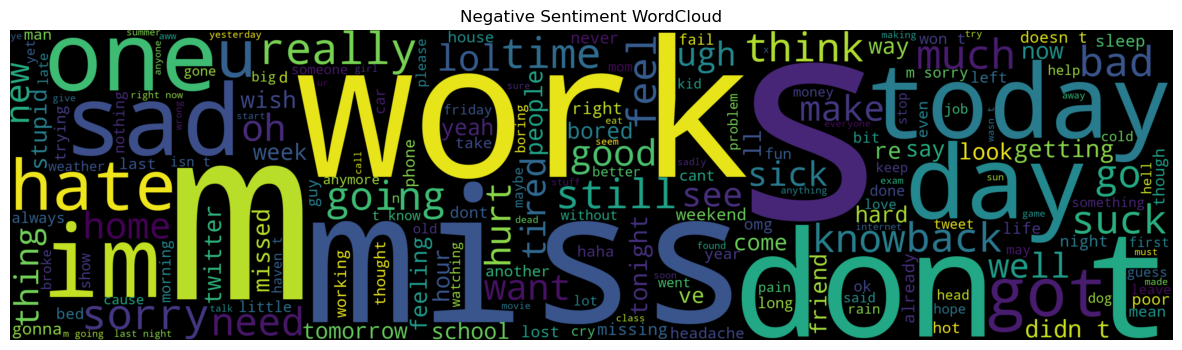

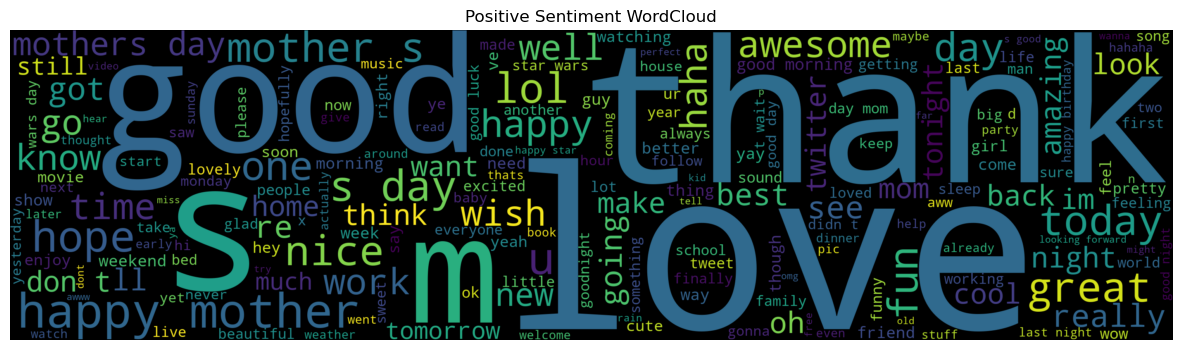

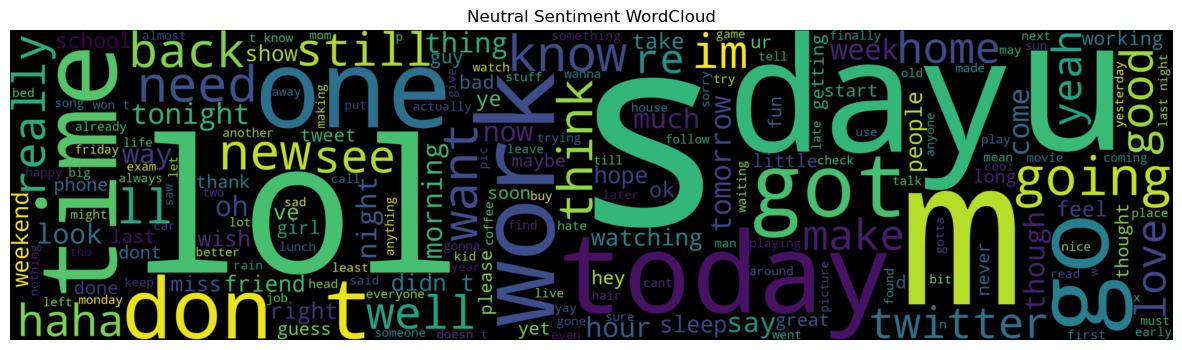

In [22]:
#Let's visualize wordcloud post cleaning
from wordcloud import WordCloud, STOPWORDS
negative_df = df[df['sentiment'] == 'negative']
positive_df = df[df['sentiment'] == 'positive']
neutral_df = df[df['sentiment'] == 'neutral']

# Define a function to generate and display a WordCloud
def generate_wordcloud(data, title):
    words = ' '.join(data['text'])
    cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT' ])
    wordcloud = WordCloud(stopwords=STOPWORDS,background_color='black', 
                          width=3000, height=800).generate(cleaned_word)
    plt.figure(figsize=(15, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()
# Generate and display WordClouds for each sentiment category
generate_wordcloud(negative_df, 'Negative Sentiment WordCloud')
generate_wordcloud(positive_df, 'Positive Sentiment WordCloud')
generate_wordcloud(neutral_df, 'Neutral Sentiment WordCloud')


In [27]:
#PREDICTIVE MODELLING
X = df['text']
y = df['sentiment']


In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer ()
X = vectorizer.fit_transform(X)
vectorizer

TfidfVectorizer()

In [30]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [31]:
#Let us create first create a table to store the results of various models 
results_df = pd.DataFrame(np.zeros((2,5)), columns=['Accuracy', 'Precision','Recall','F1-score','AUC-ROC score'])
results_df.index=['Logistic Regression (LR)','Naïve Bayes Classifier (NB)'] #'Decision Tree Classifier (DT)', 'Linear Discriminant Analysis(LDA)','Random Forest Classifier (RF)', 'Support Vector Classifier (SVC)'
results_df

,Accuracy,Precision,Recall,F1-score,AUC-ROC score
Logistic Regression (LR),0.0,0.0,0.0,0.0,0.0
Naïve Bayes Classifier (NB),0.0,0.0,0.0,0.0,0.0


In [32]:
#Let us define functions to summarise the Prediction's scores .
from scikitplot.metrics import plot_roc_curve as auc_roc
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, \
roc_auc_score, roc_curve, precision_score, recall_score

#Classification Summary Function
def Classification_Summary(pred,pred_prob,i):
    results_df.iloc[i]['Accuracy']=round(accuracy_score(y_test, pred),3)*100   
    results_df.iloc[i]['Precision']=round(precision_score(y_test, pred, average='weighted'),3)*100 #, average='weighted'
    results_df.iloc[i]['Recall']=round(recall_score(y_test, pred, average='weighted'),3)*100 #, average='weighted'
    results_df.iloc[i]['F1-score']=round(f1_score(y_test, pred, average='weighted'),3)*100 #, average='weighted'
    results_df.iloc[i]['AUC/ROC score']=round(roc_auc_score(y_test, pred_prob, multi_class='ovr'),3)*100 #, multi_class='ovr'
    print('{}{}\033[1m Evaluating {} \033[0m{}{}\n'.format('<'*3,'-'*35,results_df.index[i], '-'*35,'>'*3))
    print('Accuracy = {}%'.format(round(accuracy_score(y_test, pred),3)*100))
    print('F1 Score = {}%'.format(round(f1_score(y_test, pred, average='weighted'),3)*100)) #, average='weighted'
    print('\n \033[1mConfusiton Matrix:\033[0m\n',confusion_matrix(y_test, pred))
    print('\n\033[1mClassification Report:\033[0m\n',classification_report(y_test, pred))
    
    auc_roc(y_test, pred_prob, curves=['each_class'])
    plt.show()

In [33]:
#Visualising Function
def AUC_ROC_plot(y_test, pred):    
    ref = [0 for _ in range(len(y_test))]
    ref_auc = roc_auc_score(y_test, ref)
    lr_auc = roc_auc_score(y_test, pred)

    ns_fpr, ns_tpr, _ = roc_curve(y_test, ref)
    lr_fpr, lr_tpr, _ = roc_curve(y_test, pred)

    plt.plot(ns_fpr, ns_tpr, linestyle='--')
    plt.plot(lr_fpr, lr_tpr, marker='.', label='AUC = {}'.format(round(roc_auc_score(y_test, pred)*100,2))) 
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

In [34]:
#LOGISTIC REGRESSION MODEL
# Building Logistic Regression Classifier
from sklearn.linear_model import LogisticRegression

LR_model = LogisticRegression()
LR = LR_model.fit(X_train, y_train)

<<<----------------------------------- Evaluating Logistic Regression (LR) ----------------------------------->>>

Accuracy = 68.5%
F1 Score = 68.4%

 Confusiton Matrix:
 [[ 848  589   86]
 [ 257 1775  243]
 [  51  505 1142]]

Classification Report:
               precision    recall  f1-score   support

    negative       0.73      0.56      0.63      1523
     neutral       0.62      0.78      0.69      2275
    positive       0.78      0.67      0.72      1698

    accuracy                           0.69      5496
   macro avg       0.71      0.67      0.68      5496
weighted avg       0.70      0.69      0.68      5496



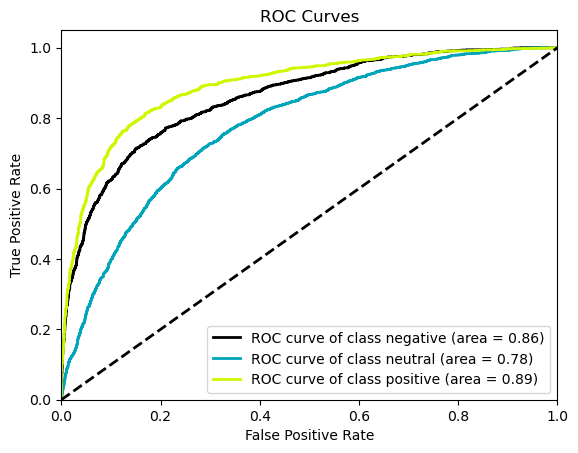

In [35]:
pred = LR.predict(X_test)
pred_prob = LR.predict_proba(X_test)
Classification_Summary(pred,pred_prob,0)

<<<----------------------------------- Evaluating Naïve Bayes Classifier (NB) ----------------------------------->>>

Accuracy = 63.1%
F1 Score = 62.4%

 Confusiton Matrix:
 [[ 648  795   80]
 [ 217 1794  264]
 [  54  620 1024]]

Classification Report:
               precision    recall  f1-score   support

    negative       0.71      0.43      0.53      1523
     neutral       0.56      0.79      0.65      2275
    positive       0.75      0.60      0.67      1698

    accuracy                           0.63      5496
   macro avg       0.67      0.61      0.62      5496
weighted avg       0.66      0.63      0.62      5496



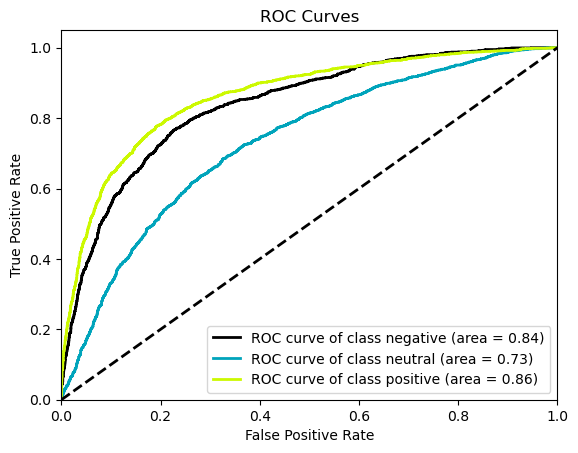

In [36]:
#NAIVE BAYES CLASSIFIER
#Naive Bayes Classfier
NB_model = BernoulliNB()
NB = NB_model.fit(X_train, y_train)
pred = NB.predict(X_test)
pred_prob = NB.predict_proba(X_test)
Classification_Summary(pred,pred_prob,1)